<a href="https://colab.research.google.com/github/kouroshkarimi/Keras-Introducing-to-Deep-Learning/blob/main/004-Resnet%20from%20scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.utils import plot_model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# ResNet

## Create residual_module


![alt text](https://i.ibb.co/ZJbM5NF/residual-module.png)

In [3]:
# Define residual layer Functional (shows in up)
def residual_module(layer_in, n_filters):
  conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
  conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
  layer_out = add([conv2, layer_in]) # add output of conv2 and layer_in index by index
  out = Activation('relu')(layer_out)
  return out


### There is a Problme :/ !

A limitation with this direct implementation is that if the number of filters in the input layer does not match the number of filters in the last convolutional layer of the module (defined by n_filters), then we will get an error.

### Projection shortcut

The projection shortcut  is used to match dimensions (done by 1×1 convolutions).

In [4]:
def residual_module(layer_in, n_filters):

  merge_input = layer_in

  if layer_in.shape[-1] != n_filters: # make same shape with conv2 in adding them (maybe in add they have not same channels we fix it here)
    merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu')(layer_in)

  conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
  conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
  layer_out = add([conv2, merge_input]) # merge_input and conv2 will have same channels
  out = Activation('relu')(layer_out)
  return out

## Model

In [5]:
# Initializeing our model (Residual Net)
X = Input(shape=(64, 64, 3))

# 1
output = residual_module(X, 64)
output = MaxPooling2D(pool_size=(2,2))(output)

# 2
output = residual_module(output, 128)
output = MaxPooling2D(pool_size=(2,2))(output)

# 3
output = residual_module(output, 256)
output = MaxPooling2D(pool_size=(2,2))(output)

# 4 
output = residual_module(output, 512)
output = MaxPooling2D(pool_size=(2,2))(output)

# conv-flatten
output = Conv2D(64, (1,1), activation='relu')(output)
output = Flatten()(output)

# Dense layer
output = Dense(512, activation='relu')(output)
output = Dense(10 , activation='softmax')(output)

# create model
model = Model(inputs = X, outputs = output)

In [6]:
# Summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   256         input_1[0][0]                    
______________________________________________________________________________________________

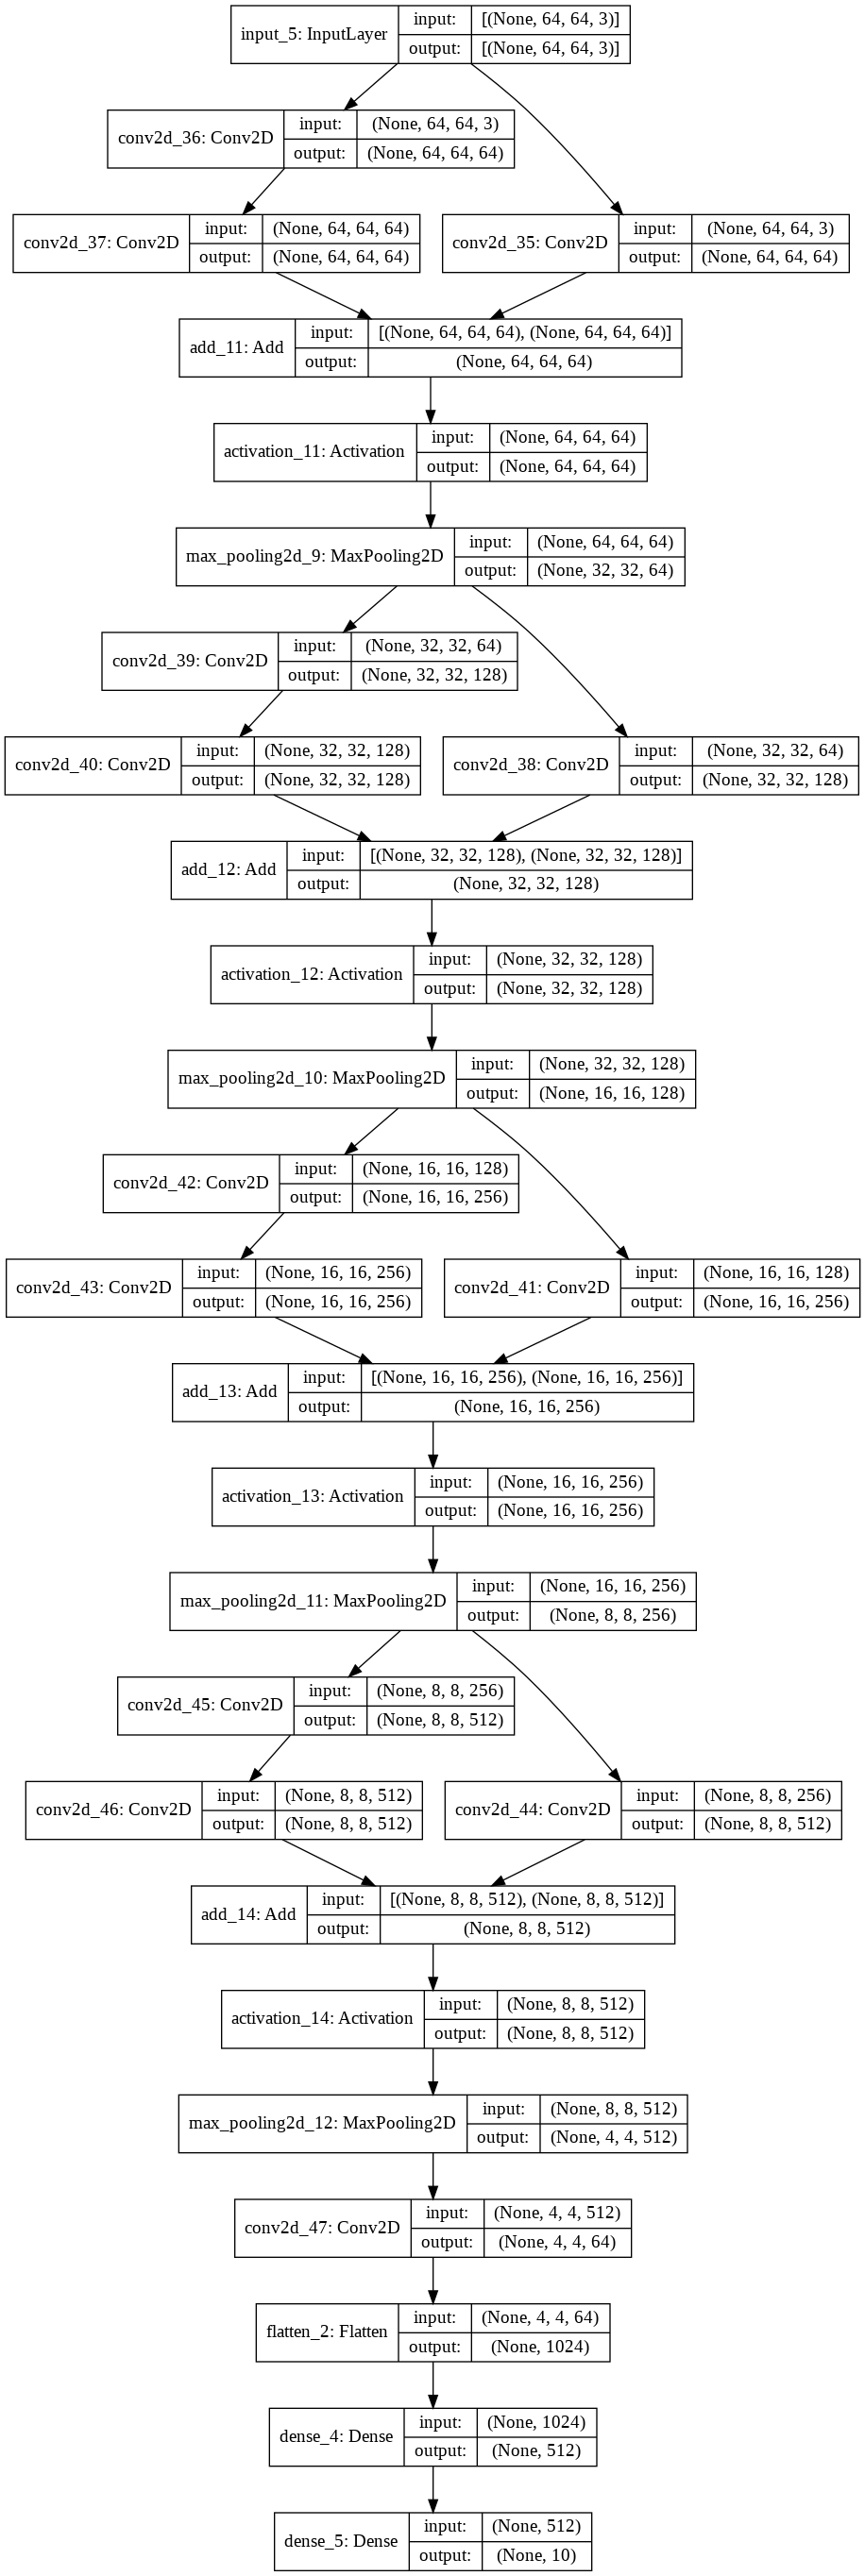

In [ ]:
# Plot the model
keras.utils.plot_model(model, show_shapes=True)

## Load data from google drive

In [7]:
# Link google colab to google drive
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
# first upload Eurosat dataset then with this code extract it
"""import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/EuroSAT.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/dataset/EuroSAT.zip')
zip_ref.close()"""

BadZipFile: ignored

In [ ]:
import os
DIR = '/content/drive/My Drive/Colab Notebooks/dataset/EuroSAT/2750'
class_names = os.listdir(DIR)
class_names

['River',
 'AnnualCrop',
 'HerbaceousVegetation',
 'Industrial',
 'Residential',
 'Highway',
 'Pasture',
 'Forest',
 'SeaLake',
 'PermanentCrop']

### ImageDataGenerator

In [ ]:
# Data Generate (here we have not augmentation just rescaling and validation split)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

#### read data from directory 

In [ ]:
# split training our data and set batch size
training_set = train_datagen.flow_from_directory(
    DIR, 
    target_size = (64,64),
    batch_size = 32, 
    class_mode = 'categorical', 
    subset = 'training')

In [ ]:
# split validation (0.2) our data and set batch size
validation_set = train_datagen.flow_from_directory(
    DIR,
    target_size = (64,64)
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'  
)

### plot data

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = training_set[0][0][i]
    plt.imshow(img)
    plt.axis('off')
    
# show the plot
plt.show()

### compile and fit model

In [ ]:
# compile (compile our model with adam optimizer)
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy',])

In [ ]:
history = model.fit()



---

---





Transform learning

In [ ]:
# here we use keras application (Resnet50) (trained model with imagenet) (it will download wights)
# include top classification (false for our learning then define our shape input)
resnet = keras.applications.resnet.ResNet50(weights='imagenet', 
                                            include_top=False, 
                                            input_shape = (64,64,3)) 


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# costumize resnet with our objective (with include_top=False 2 last layer removed and we can costomize it)
model = keras.Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [ ]:
# it get resnet50 one layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                10250     
Total params: 31,987,594
Trainable params: 31,934,474
Non-trainable params: 53,120
_________________________________________________________________


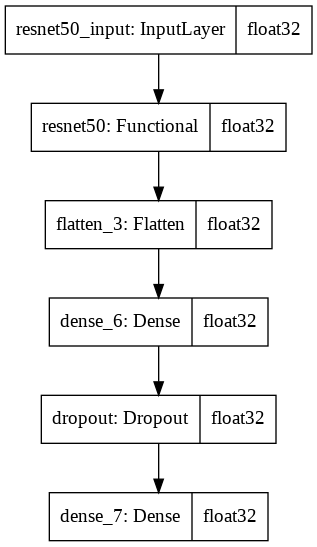

In [ ]:
keras.utils.plot_model(model)

 ### dense layers are not trained but our resnet is trained. for some epochs we freeze resnet to learn a little our dense layer. (this work when we want train imagenet)
 * Freeze resnet weight
 * Train model for 5 epochs
 * Unfreeze resnet weights 
 ## Do not forget to compile after unfreezing

In [ ]:
# freeze resnet weights
for lay in model.layers[0].layers:
  lay.trainable = False
  

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.2, momentum=0.9)
model.compile(loss = keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(training_set,
                    epochs = 5,
                    validatin_data = validation_set,
                    validation_step = validation_set.sample // 32,
                    step_per_epoch = trainig_set.sample // 32)

In [ ]:
# unfreeze resnet weights
for lay in model.layers[0].layers:
  lay.trainable = False
  

In [ ]:
# compile after unfreeze
optimizer = keras.optimizers.SGD(lr = 0.2, momentum=0.9)
model.compile(loss = '', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(training_set,
                    epochs = 5,
                    validatin_data = validation_set,
                    validation_step = validation_set.sample // 32,
                    step_per_epoch = trainig_set.sample // 32)

In [ ]:
for index ,layer in enumerate(resnet.layers):
  print(index, layer.name, layer.trainable)

0 input_7 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru